In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data Preprocessing

In [4]:
data_folder = "data/"

price_files = [
    "prices_round_1_day_-2.csv",
    # "prices_round_1_day_-1.csv",
    # "prices_round_1_day_0.csv",
]

trade_files = [
    "trades_round_1_day_-2.csv",
    # "trades_round_1_day_-1.csv",
    # "trades_round_1_day_0.csv",
]

In [5]:
prices = pd.concat([
    pd.read_csv(data_folder + file, sep=';') 
    for file in price_files
])

trades = pd.concat([
    pd.read_csv(data_folder + file, sep=';')
    for file in trade_files
])

In [6]:
squid_trades = trades[(trades['symbol'] == "SQUID_INK") & (trades['quantity'] > 1)]
squid_trades = squid_trades[['timestamp', 'price', 'quantity']]
squid_trades.head()

,timestamp,price,quantity
5,100,2001.0,6
7,1000,1999.0,10
19,2100,2001.0,4
22,2500,1999.0,11
28,3300,1999.0,2


In [7]:
squid_prices = prices[prices['product'] == "SQUID_INK"]
squid_prices = squid_prices.fillna(0)
squid_prices.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
2,-2,0,SQUID_INK,1998,26,0.0,0.0,0.0,0.0,2002,26,0.0,0.0,0.0,0.0,2000.0,0.0
3,-2,100,SQUID_INK,1999,5,1998.0,26.0,0.0,0.0,2001,20,0.0,0.0,0.0,0.0,2000.0,0.0
7,-2,200,SQUID_INK,1997,31,0.0,0.0,0.0,0.0,2000,1,2001.0,30.0,0.0,0.0,1998.5,0.0
11,-2,300,SQUID_INK,1997,27,0.0,0.0,0.0,0.0,2000,27,0.0,0.0,0.0,0.0,1998.5,0.0
14,-2,400,SQUID_INK,1996,20,0.0,0.0,0.0,0.0,2000,20,0.0,0.0,0.0,0.0,1998.0,0.0


# Numpy ily

In [8]:
fml = pd.DataFrame()

In [9]:
from collections import defaultdict

D = defaultdict(lambda: defaultdict(int))
for _, (timestamp, price, quantity) in squid_trades.iterrows():
    D[timestamp][price] += quantity

data = []
for timestamp in D:
    max_vol_price = max(D[timestamp], key=D[timestamp].get)
    data.append((timestamp, max_vol_price))

max_vol_squid_trades = pd.DataFrame(data, columns=['timestamp', 'max_vol_trade_price'])
max_vol_squid_trades.head()

,timestamp,max_vol_trade_price
0,100.0,2001.0
1,1000.0,1999.0
2,2100.0,2001.0
3,2500.0,1999.0
4,3300.0,1999.0


In [10]:
def get_max_volume_bid_price(row):
    bid_volumes = [row['bid_volume_1'], row['bid_volume_2'], row['bid_volume_3']]
    bid_prices = [row['bid_price_1'], row['bid_price_2'], row['bid_price_3']]
    
    max_volume_index = np.argmax(bid_volumes)
    return bid_prices[max_volume_index]

squid_prices['max_vol_bid_price'] = squid_prices.apply(get_max_volume_bid_price, axis=1)
squid_prices[['timestamp', 'max_vol_bid_price']]

,timestamp,max_vol_bid_price
2,0,1998.0
3,100,1998.0
7,200,1997.0
11,300,1997.0
14,400,1996.0
...,...,...
29986,999500,2000.0
29990,999600,2001.0
29992,999700,2001.0
29994,999800,2002.0


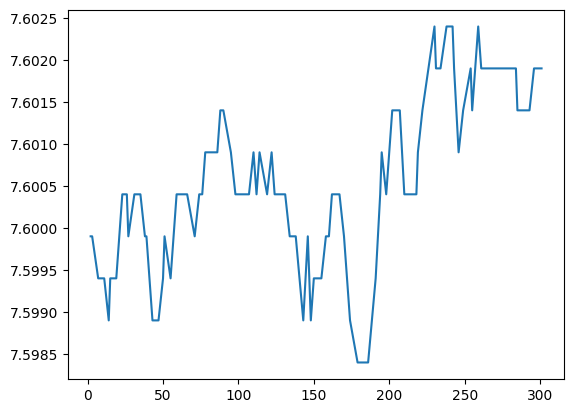

In [11]:
log_prices = np.log(squid_prices[squid_prices['timestamp'] <= 10_000]['max_vol_bid_price'])
plt.plot(log_prices)


In [12]:
def get_max_volume_ask_price(row):
    ask_volumes = [row['ask_volume_1'], row['ask_volume_2'], row['ask_volume_3']]
    ask_prices = [row['ask_price_1'], row['ask_price_2'], row['ask_price_3']]
    
    max_volume_index = np.argmax(ask_volumes)
    return ask_prices[max_volume_index]

squid_prices['max_vol_ask_price'] = squid_prices.apply(get_max_volume_ask_price, axis=1)
squid_prices[['timestamp', 'max_vol_ask_price']]

,timestamp,max_vol_ask_price
2,0,2002.0
3,100,2001.0
7,200,2001.0
11,300,2000.0
14,400,2000.0
...,...,...
29986,999500,2003.0
29990,999600,2004.0
29992,999700,2005.0
29994,999800,2005.0


In [13]:
squid_prices = squid_prices.merge(max_vol_squid_trades, how="left", on="timestamp")

In [14]:
squid_prices["max_vol_bid_price"].autocorr(lag=50)

np.float64(0.9758390715219163)

In [15]:
from statsmodels.tsa.stattools import adfuller

series = squid_prices["max_vol_bid_price"]
result = adfuller(series)
print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")


ADF Statistic: -1.5764278576723778, p-value: 0.4954228111123399



"p > 0.05 -> the series is non-stationary (subtract previous values)"

In [16]:
type(series)

pandas.core.series.Series

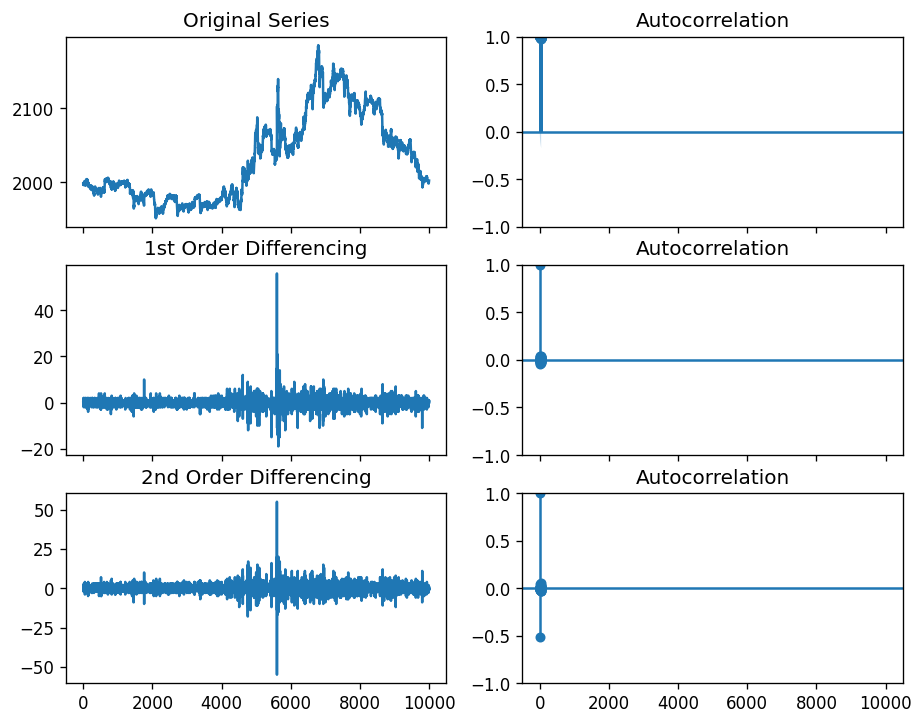

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(series); axes[0, 0].set_title('Original Series')
plot_acf(series, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(series.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(series.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(series.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Going with second order differencing.

# d = 2 fixed.
# p = 2 (tweak).
# q = 2 (tweak). 

In [18]:
from statsmodels.tsa.arima.model import ARIMA

start = 400
end = 500
train_series = series.iloc[:end]
test_series = series.iloc[end:end+50]

p, d, q = 2, 2, 2
model = ARIMA(train_series, order=(p,d,q))
model_fit = model.fit()
# print(model_fit.summary())

In [19]:
predictions = model_fit.forecast(15)
predictions 

500    1990.963240
501    1990.972459
502    1990.935709
503    1990.943954
504    1990.908259
505    1990.915462
506    1990.880785
507    1990.886994
508    1990.853287
509    1990.858549
510    1990.825767
511    1990.830126
512    1990.798226
513    1990.801724
514    1990.770664
Name: predicted_mean, dtype: float64

## Now the weird stuff

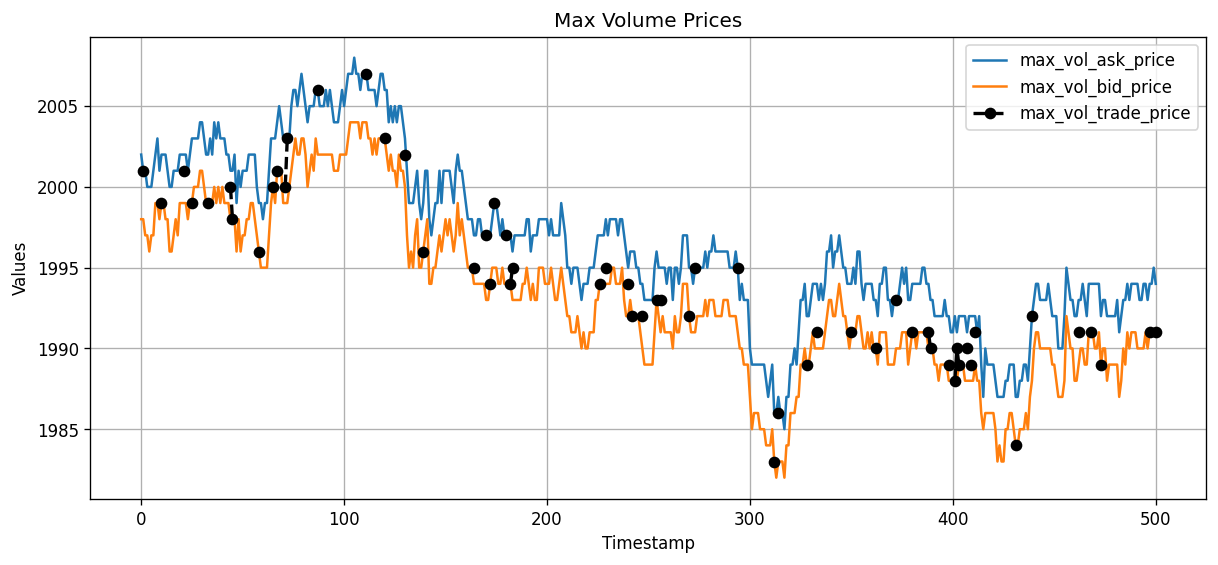

In [20]:
start = 0
end = 50_000

df = squid_prices[(start <= squid_prices["timestamp"]) & (squid_prices["timestamp"] <= end)]
# Plot ask and bid prices normally
ax = df[['max_vol_ask_price', 'max_vol_bid_price']].plot(figsize=(12, 5), lw=1.5)

# Plot max_vol_trade_price with a custom "o--" style
df['max_vol_trade_price'].plot(ax=ax, linestyle='--', marker='o', markersize=6, color='black', lw=2, label='max_vol_trade_price')

plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Max Volume Prices')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
squid_prices

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,max_vol_bid_price,max_vol_ask_price,max_vol_trade_price
0,-2,0,SQUID_INK,1998,26,0.0,0.0,0.0,0.0,2002,26,0.0,0.0,0.0,0.0,2000.0,0.0,1998.0,2002.0,NaN
1,-2,100,SQUID_INK,1999,5,1998.0,26.0,0.0,0.0,2001,20,0.0,0.0,0.0,0.0,2000.0,0.0,1998.0,2001.0,2001.0
2,-2,200,SQUID_INK,1997,31,0.0,0.0,0.0,0.0,2000,1,2001.0,30.0,0.0,0.0,1998.5,0.0,1997.0,2001.0,NaN
3,-2,300,SQUID_INK,1997,27,0.0,0.0,0.0,0.0,2000,27,0.0,0.0,0.0,0.0,1998.5,0.0,1997.0,2000.0,NaN
4,-2,400,SQUID_INK,1996,20,0.0,0.0,0.0,0.0,2000,20,0.0,0.0,0.0,0.0,1998.0,0.0,1996.0,2000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-2,999500,SQUID_INK,2000,26,0.0,0.0,0.0,0.0,2003,26,0.0,0.0,0.0,0.0,2001.5,0.0,2000.0,2003.0,NaN
9996,-2,999600,SQUID_INK,2001,30,0.0,0.0,0.0,0.0,2004,30,0.0,0.0,0.0,0.0,2002.5,0.0,2001.0,2004.0,NaN
9997,-2,999700,SQUID_INK,2001,22,0.0,0.0,0.0,0.0,2005,22,0.0,0.0,0.0,0.0,2003.0,0.0,2001.0,2005.0,NaN
9998,-2,999800,SQUID_INK,2002,26,0.0,0.0,0.0,0.0,2004,3,2005.0,26.0,0.0,0.0,2003.0,0.0,2002.0,2005.0,NaN


In [22]:
from statsmodels.tsa.stattools import adfuller

# Extract price series
price_series = squid_prices['max_vol_trade_price'].dropna()

# Perform ADF test
adf_result = adfuller(price_series)

# Display results
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')


ADF Statistic: -1.3957550880353728
p-value: 0.5843094822216843
Critical Values:
   1%: -3.4360840741163168
   5%: -2.864071964072552
   10%: -2.568118081861596


In [23]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

In [24]:
def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts

    Parameters
    ----------
    ts : `numpy.array`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the poly fit output
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [25]:
hurst(price_series)

/var/folders/41/v7x6qrn91r5ccc86q_ps3c7c0000gn/T/ipykernel_42069/1080771817.py:22: RuntimeWarning: divide by zero encountered in log
  poly = polyfit(log(lags), log(tau), 1)


np.float64(nan)